# Semi-Gradient vs. Full-Gradient #

## DQN ##

In [2]:
%matplotlib inline
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
import matplotlib.pyplot as plt
import sys
import time
import gym
import datetime as datetime
import pandas as pd

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [3]:
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)
        
    def forward(self, x):
          out=self.l1(x)
          out=F.relu(out)
          out=self.l2(out)
        
          return out
        
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        
    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory)>self.capacity:
            self.memory=self.memory[1:]
            
    def sample(self, batch_size):
        return random.sample(self.memory,batch_size)
            
    def __len__(self):
        return len(self.memory)
    
def get_epsilon(it):
    epsilon =np.maximum(1+ - .95*((it)/1000),.05)
    
    return epsilon

class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  
        Args:
            obs: current state
        Returns:
            An action (int).
            
        """
        with torch.no_grad():
            obs = torch.tensor(obs, dtype=torch.float)
            q=self.Q(obs)
            p=random.random()
            if p<self.epsilon:
                return   int(len(q) * p/self.epsilon)
            else:
                return np.argmax(q).item()
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon
        
def compute_q_vals(Q, states, actions):
    try:
        return torch.gather(Q.forward(states),1, actions)
    except:
        return Q_net.forward(states)[actions].flatten()

    
def compute_targets(Q, rewards, next_states, dones, discount_factor):
    """
    This method returns targets (values towards which Q-values should move).
    
    Args:
        Q: Q-net
        rewards: a tensor of actions. Shape: Shape: batch_size x 1
        next_states: a tensor of states. Shape: batch_size x obs_dim
        dones: a tensor of boolean done flags (indicates if next_state is terminal) Shape: batch_size x 1
        discount_factor: discount
    Returns:
        A torch tensor filled with target values. Shape: batch_size x 1.
    """

    dones=dones.squeeze()
    ndmask=(1-dones.type(torch.FloatTensor))
    
    targets= rewards.squeeze()+(discount_factor*torch.max(Q(next_states),1)[0])*ndmask.flatten()

    return targets.reshape(len(dones),1)

def train(Q, memory, optimizer, batch_size, discount_factor,semi):
    # DO NOT MODIFY THIS FUNCTION
    loss_func = nn.MSELoss()
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None
    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)[:, None]  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)[:, None]
    
    done = torch.tensor(done, dtype=torch.uint8)[:, None]  # Boolean
    
    # compute the q value
    q_val = compute_q_vals(Q, state, action)
    if semi==True:
        with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
            target = compute_targets(Q, reward, next_state, done, discount_factor)
    else:
        target = compute_targets(Q, reward, next_state, done, discount_factor)

    loss = loss_func(q_val, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate, semi):
#     print(episode_durations)
    optimizer = optim.Adam(Q.parameters(), learn_rate)

  
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = [] 
    global_iter = 0
    for i in range(num_episodes):
        state = env.reset()
        steps = 0
        while True:
            steps=steps+1
            epsilon=get_epsilon(global_steps)
            policy.set_epsilon(epsilon)
            a = policy.sample_action(state)
            ns, reward, done, _ = env.step(a)
            memory.push((state, a, reward, ns, done))
            train(Q, memory, optimizer, batch_size, discount_factor,semi)
            state=ns
            global_steps=global_steps+1
            if done:
                if i % 100 == 0:
                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                break
  
    return episode_durations

In [4]:
# Let's run it!
num_episodes = 1000
batch_size = 64
#discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
env = gym.envs.make("CartPole-v1")

x=datetime.datetime.now()
for semib in [True, False]:
    results={}
    counter=0
    for seed in range(10):
        for epsilon in [0.0]:
            for discount_factor in [1]:
                # We will seed the algorithm (before initializing QNetwork!) for reproducibility
                random.seed(seed)
                torch.manual_seed(seed)
                env.seed(seed)

                Q_net = QNetwork(num_hidden)
                policy = EpsilonGreedyPolicy(Q_net, epsilon)
                episode_durations1 = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,semi=semib)
                
                results[counter]={'EpisodeDuration':episode_durations1,'Seed':seed,'SemiB':semib,'Epsilon':epsilon,'DisFactor':discount_factor}

                counter=counter+1
        print(seed, datetime.datetime.now()-x)
    results_df=pd.DataFrame(results).T
    results_df.to_json('results_semi_{}.json'.format(semib))

C:\Users\tczin\AppData\Local\Continuum\anaconda3\envs\rl2020\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


 Episode 0 finished after 21 steps
 Episode 100 finished after 500 steps
 Episode 200 finished after 192 steps
 Episode 300 finished after 154 steps
 Episode 400 finished after 225 steps
 Episode 500 finished after 285 steps
 Episode 600 finished after 182 steps
 Episode 700 finished after 155 steps
 Episode 800 finished after 124 steps
 Episode 900 finished after 174 steps
0 0:06:08.264930
 Episode 0 finished after 21 steps
 Episode 100 finished after 9 steps
 Episode 200 finished after 21 steps
 Episode 300 finished after 307 steps
 Episode 400 finished after 500 steps
 Episode 500 finished after 112 steps
 Episode 600 finished after 12 steps
 Episode 700 finished after 273 steps
 Episode 800 finished after 183 steps
 Episode 900 finished after 186 steps
1 0:11:27.553378
 Episode 0 finished after 20 steps
 Episode 100 finished after 8 steps
 Episode 200 finished after 31 steps
 Episode 300 finished after 98 steps
 Episode 400 finished after 322 steps
 Episode 500 finished after 188 s

In [6]:
results_df

,EpisodeDuration,Seed,SemiB,Epsilon,DisFactor
0,"[21, 16, 28, 17, 15, 34, 21, 16, 19, 41, 14, 1...",0,True,0,0.95
1,"[21, 26, 24, 27, 17, 24, 37, 12, 24, 14, 11, 1...",1,True,0,0.95
2,"[20, 29, 25, 11, 16, 19, 13, 30, 14, 22, 20, 4...",2,True,0,0.95
3,"[19, 12, 13, 29, 14, 20, 13, 9, 28, 16, 37, 21...",3,True,0,0.95
4,"[25, 11, 12, 17, 25, 10, 34, 29, 13, 24, 39, 1...",4,True,0,0.95
5,"[17, 17, 14, 28, 13, 21, 59, 9, 11, 18, 18, 35...",5,True,0,0.95
6,"[25, 32, 21, 13, 17, 22, 13, 21, 10, 13, 14, 1...",6,True,0,0.95
7,"[18, 19, 26, 26, 11, 30, 24, 19, 23, 14, 14, 2...",7,True,0,0.95
8,"[78, 9, 25, 47, 18, 9, 12, 13, 17, 15, 14, 17,...",8,True,0,0.95
9,"[24, 25, 11, 16, 34, 28, 18, 19, 13, 15, 14, 1...",9,True,0,0.95


## Plot Results ##

(10, 1000)
(10, 1000)


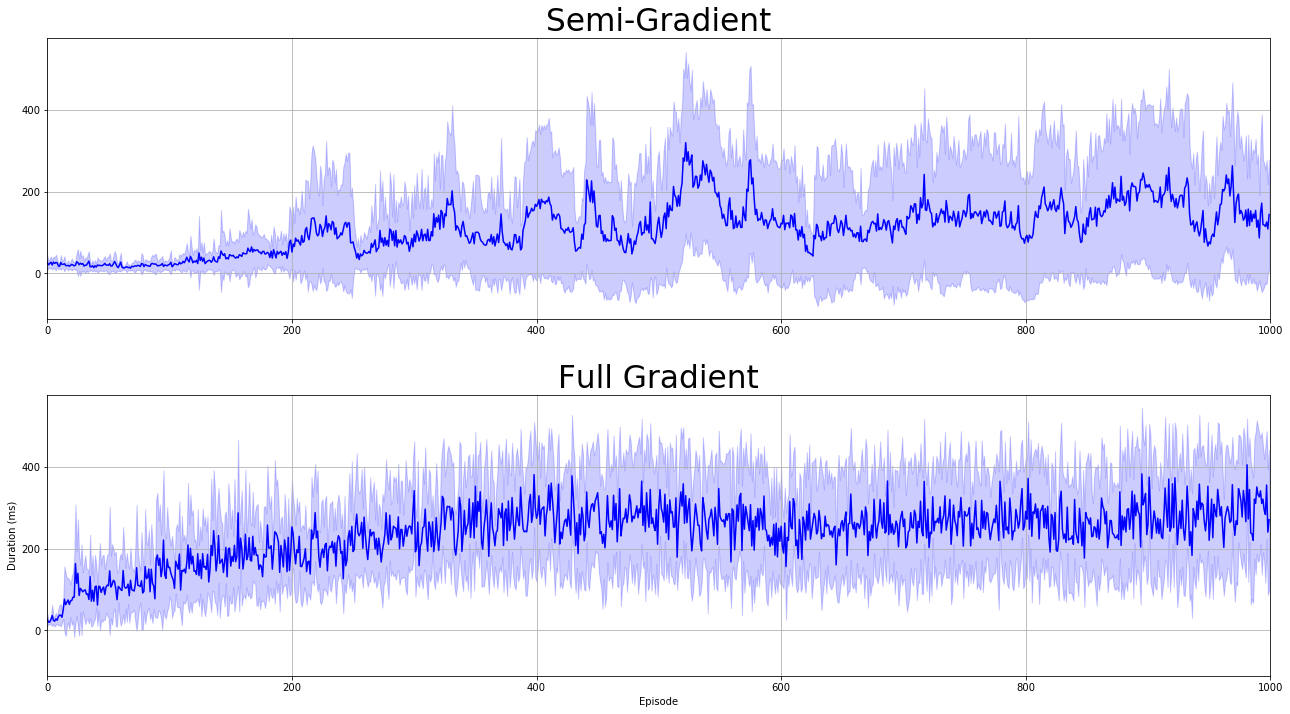

In [4]:
files = ['results_semi_True.json', 'results_semi_False.json']
n = 0
fig, axs = plt.subplots(2, sharey=True)
for file in files:
    results_df = pd.read_json(file)
    if results_df.shape[0] != 10:
        results_df = results_df.loc[10:, :]
        results_df.reset_index(drop=True, inplace=True)
    tmp = []
    for i in range(10):
        tmp.append(results_df.loc[i, 'EpisodeDuration'])
    durations_np = np.array(tmp)
    print(durations_np.shape)
    mean = durations_np.mean(axis=0)
    std = durations_np.std(axis=0)
    plt.rcParams.update({'font.size': 26})

    axs[n].plot(range(len(mean)), mean, '-', color='blue')

    axs[n].fill_between(range(len(mean)), mean-std, mean+std,
                     color='blue', alpha=0.2)
    if n == 0:
        axs[n].set_title('Semi-Gradient')
    else:
        axs[n].set_title('Full Gradient')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Duration (ms)')
    axs[n].grid(True)
    axs[n].set_xlim([0, 1000])

    n += 1


fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
plt.savefig('cart_pole_semi.pdf', bbox_inches='tight')
